This notebook takes the extracted surface of the kernel and plots it,
along with the seismograms, and colour bars as in the paper. Some small
analysis is also performed to provide some statistics.

The code in this notebook is made available under the [GPLv2 license](../LICENSE.md).

In [1]:
import itertools
import os
from collections import defaultdict, namedtuple

import numpy as np

# Plotting
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

# For azimuth and distance calculations.
from geographiclib.geodesic import Geodesic

# Filtering
import obspy
from obspy.core import Stream, Trace, Stats, UTCDateTime
assert hasattr(obspy, '__version__') and obspy.__version__[0] >= '1', \
    'ObsPy is too old to filter correctly. Please install 1.0.0 or newer.'

# To read the CMTSOLUTION file.
from obspy import read_events

In [2]:
# Some values from constants.h
R_EARTH = 6371000
R_EARTH_KM = R_EARTH / 1000
FLATTENING_F = 1.0 / 299.8e0

In [3]:
# GJI class says text width is 42 picas.
FIG_WIDTH = 42 * 12 / 72.27
# Two rows by three columns of spheres with two title lines.
FIG_HEIGHT = 2 * (FIG_WIDTH * 0.32) + 2 * 12 / 72.27
# Limit for colour bar.
LIM = 2e-7
CMAP_SCALE = 7

In [4]:
# Cutting windows for adjoint sources.
START_50_100 = 3395
END_50_100 = 3595
START_100_200 = 3390 
END_100_200 = 3825

In [5]:
# Directories and full/short names for labelling.
UNDO_TYPES = ['exact', 'ppd', 'undo']
UNDO_NAMES = ['Exact Attenuation (Process A)',
              'Physical Dispersion Only (Process B)',
              'Exact Attenuation (Process C)']
UNDO_NAMES_SEISMO = ['Process A', 'Process B', 'Process C']

In [6]:
# From Colorbrewer Set1.
RED = '#e41a1c'
GREEN = '#4daf4a'
BLUE = '#377eb8'

In [7]:
# The STIX font blends well with Times (as used in GJI).
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = ['STIXGeneral']

In [8]:
# NOTE: The mesh should be the same no matter which method is used.
BASEDIR = 'exact/step1-forward/DATA'

In [9]:
cmt = os.path.join(BASEDIR, 'CMTSOLUTION')
sta = os.path.join(BASEDIR, 'STATIONS_ADJOINT')
parfile = os.path.join(BASEDIR, 'Par_file')

# Load kernel data

In [10]:
SurfaceData = namedtuple('SurfaceData', 'latitude longitude alpha_kernel')

kernel = defaultdict(dict)

for undo_type in ['exact', 'ppd', 'undo']:
    for filt in ['50s-100s', '100s-200s']:
        filename = os.path.join(undo_type,
                                'step2-adjoint',
                                filt,
                                'OUTPUT_FILES',
                                'reg_1_surface_alpha_kernel.npz')

        with np.load(filename) as file_data:
            data = SurfaceData(latitude=file_data['latitude'],
                               longitude=file_data['longitude'],
                               alpha_kernel=np.ma.MaskedArray(file_data['alpha_kernel'],
                                                              file_data['alpha_kernel_mask']))

        kernel[undo_type][filt] = data
        kernel[filt][undo_type] = data

# Load seismograms and filter them in two frequency bands

In [11]:
def read_specfem_seismogram(output_files, network, station, band):
    st = Stream()
    for component in 'ZNE':
        channel = '%sX%s' % (band, component)
        filename = os.path.join(output_files,
                                '%s.%s.%s.sem.ascii' % (network, station, channel))
        tmp = np.genfromtxt(filename)

        stats = Stats()
        stats.network = network
        stats.station = station
        stats.channel = channel
        stats.delta = tmp[1, 0] - tmp[0, 0]
        stats.npts = tmp.shape[0]
        stats.starttime = tmp[0, 0]

        tr = Trace(tmp[:, 1], stats)
        st += tr

    return st

<IPython.core.display.Javascript object>


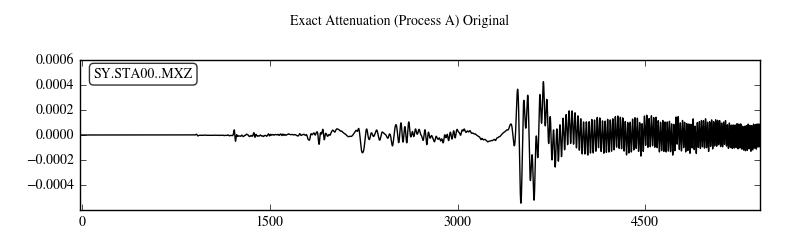

<IPython.core.display.Javascript object>


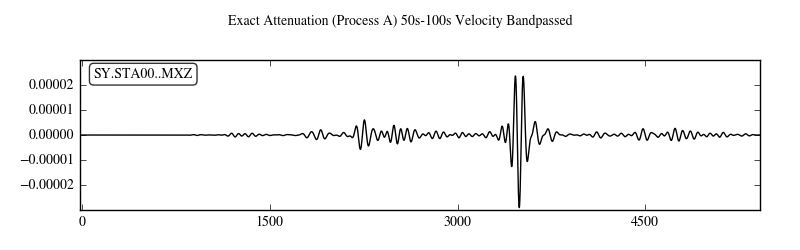

<IPython.core.display.Javascript object>


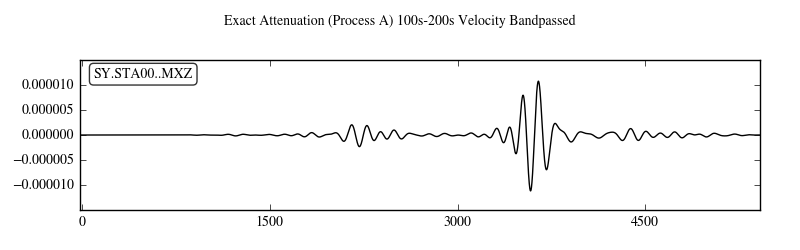

<IPython.core.display.Javascript object>


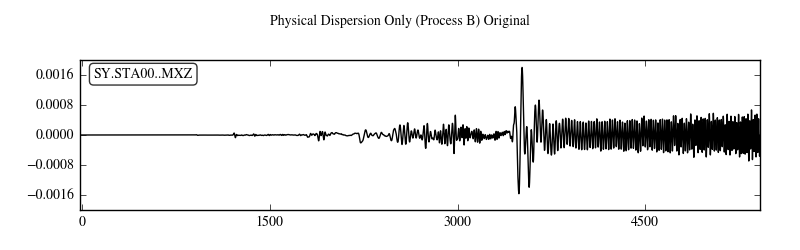

<IPython.core.display.Javascript object>


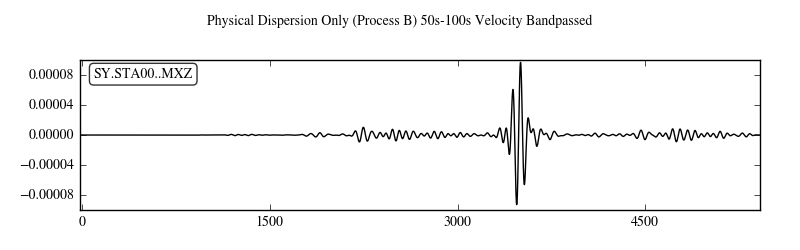

<IPython.core.display.Javascript object>


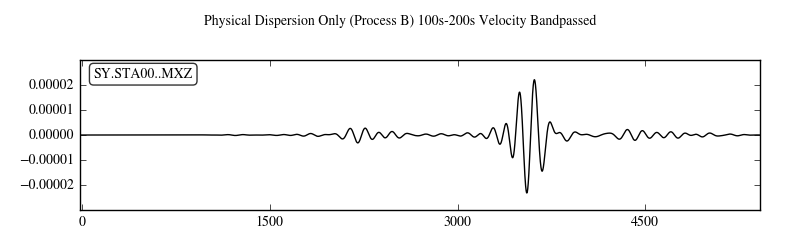

<IPython.core.display.Javascript object>


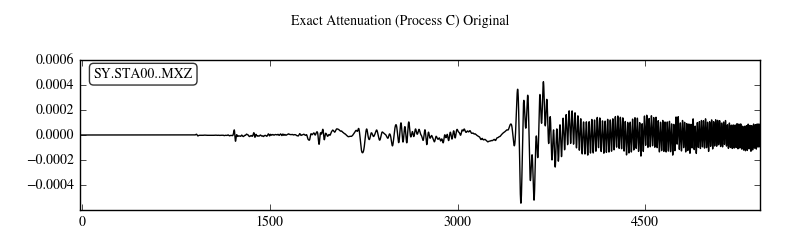

<IPython.core.display.Javascript object>


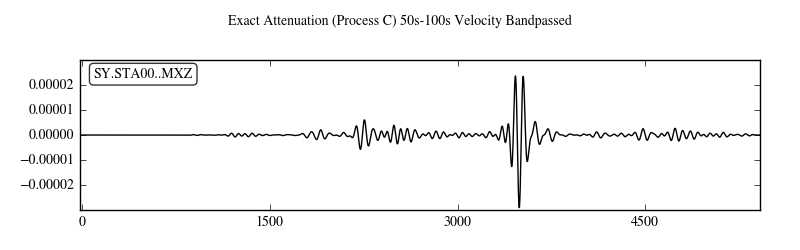

<IPython.core.display.Javascript object>


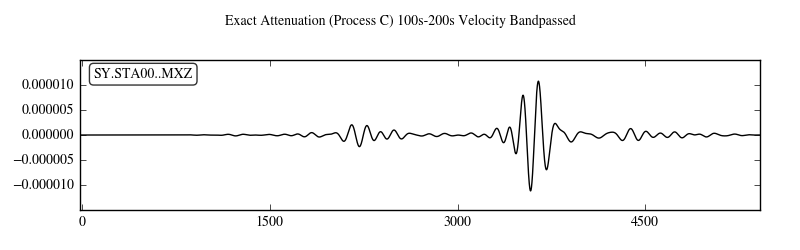

In [12]:
seismo = defaultdict(dict)

for undo_type, undo_name in zip(UNDO_TYPES, UNDO_NAMES):
    output_files = os.path.join(undo_type, 'step1-forward', 'OUTPUT_FILES')
    st = read_specfem_seismogram(output_files, 'SY', 'STA00', 'M').select(component='Z')
    st.label = '%s Original' % (undo_name, )
    st.plot(type='relative', reftime=UTCDateTime(0),
            # Prevent ObsPy from closing the figure prematurely.
            handle=True)

    for low_period, high_period in [(50, 100), (100, 200)]:
        filt = '%ds-%ds' % (low_period, high_period)

        disp = st.copy()
        disp.detrend('linear').filter('bandpass',
                                      freqmin=1.0 / high_period,
                                      freqmax=1.0 / low_period,
                                      zerophase=True)
        disp.label = '%s %s Displacement' % (undo_name, filt)
        #disp.plot(type='relative', reftime=UTCDateTime(0),
        #          # Prevent ObsPy from closing the figure prematurely.
        #          handle=True)

        vel = disp  # If we want to keep original displacement, then add a .copy() here.
        vel.differentiate()
        vel.label = '%s %s Velocity Bandpassed' % (undo_name, filt)

        vel.plot(type='relative', reftime=UTCDateTime(0),
                 # Prevent ObsPy from closing the figure prematurely.
                 handle=True)
        seismo[undo_type][filt] = vel
        seismo[filt][undo_type] = vel

# Determine point in middle of ray path

## Find event location

In [13]:
# Obtain event location
origin = read_events(cmt, format='CMTSOLUTION')[0].preferred_origin()
event_lat = origin.latitude
event_lon = origin.longitude

## Find station location

In [14]:
# Obtain station location
data = np.genfromtxt(sta)
if data.ndim != 1:
    raise ValueError('ERROR: STATIONS_ADJOINT files "%s" should contain only one '
                     'station!' % (sta, ))
station_lat = data[2]
station_lon = data[3]

## Find midpoint

In [15]:
geod = Geodesic.WGS84.Inverse(event_lat, event_lon,
                              station_lat, station_lon)
central_point = Geodesic.WGS84.Direct(geod['lat1'], geod['lon1'], geod['azi1'],
                                      geod['s12'] / 2)
central_point

{'a12': 60.09675809276512,
 'azi1': -70.00000024903986,
 'azi2': -65.94025289596505,
 'lat1': -16.08,
 'lat2': 8.4987547574479,
 'lon1': 168.31,
 'lon2': 113.047789820508,
 's12': 6667972.4752460485}

# Plot data on an orthographic sphere

In [16]:
def plot_sphere(bbox, data, name):
    """
    Plot data on an orthographic sphere.

    The axes are created at bbox, with an Orthographic projection centred
    on the middle of the ray path.
    """
    globe = ccrs.Globe(semimajor_axis=R_EARTH, flattening=FLATTENING_F)
    proj = ccrs.Orthographic(central_latitude=central_point['lat2'],
                             central_longitude=central_point['lon2'],
                             globe=globe)
    ax = fig.add_axes(bbox, projection=proj)
    ax.set_global()

    mesh = ax.pcolormesh(data.longitude, data.latitude, data.alpha_kernel,
                         cmap='RdBu', vmin=-LIM, vmax=LIM, edgecolor='none',
                         transform=ccrs.PlateCarree(), rasterized=True)

    # Station/event markers.
    ax.scatter(event_lon, event_lat,
               c=RED, s=75, marker='*', transform=ccrs.Geodetic(), zorder=10)
    ax.scatter(station_lon, station_lat,
               c=GREEN, s=75, marker='v', transform=ccrs.Geodetic(), zorder=10)

    ax.coastlines(resolution='110m')
    ax.gridlines()

    # We don't have the entire global surface, so fill the background with 
    # the middle colour (== 0.0 once the colour range is set.)
    ax.background_patch.set_color(plt.cm.RdBu(0.5))

    ax.set_title(r'$\mathbf{(%s)}$ %s' % (next(subfigs), name),
                 fontsize=8)

    return mesh

In [17]:
plt.close('all')
redraw = True

<IPython.core.display.Javascript object>


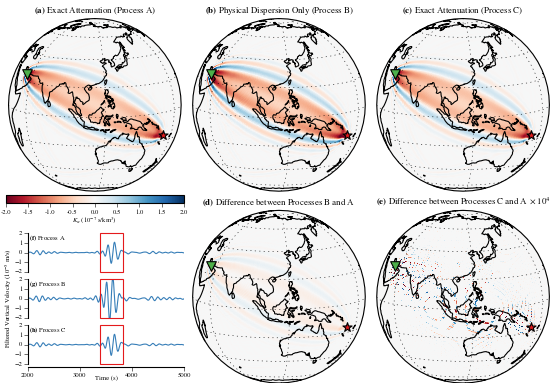

In [18]:
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
meshes = {}
subfigs = iter(chr(ord('a') + i % 26) for i in itertools.count())

In [19]:
# First row contains results.

for i, (undo_type, name) in enumerate(zip(UNDO_TYPES, UNDO_NAMES)):
    bbox = [0.01 + 0.33 * i, 0.5, 0.32, 0.45]

    this_data = kernel['100s-200s'][undo_type]

    meshes[undo_type] = plot_sphere(bbox, this_data, name)

if redraw:
    fig.canvas.draw()

/home/elliott/.local/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


In [20]:
# Second row (excluding first column) shows difference with exact result.

exact_kernel = kernel['100s-200s']['exact']

for i, undo_type in enumerate(UNDO_TYPES[1:]):
    bbox = [0.01 + 0.33 * (i + 1), 0, 0.32, 0.45]

    if undo_type == 'undo':
        scale = 1e4
        name = r'Difference between Processes C and A ${} \times 10^4$'
    else:
        scale = 1
        name = 'Difference between Processes B and A'

    this_data = kernel['100s-200s'][undo_type]
    diff_data = SurfaceData(this_data.latitude, this_data.longitude,
                            (this_data.alpha_kernel - exact_kernel.alpha_kernel) * scale)

    meshes[undo_type + '-diff'] = plot_sphere(bbox, diff_data, name)

if redraw:
    fig.canvas.draw()

/home/elliott/.local/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


In [21]:
# Show a colour bar, with some fixed limits, below the exact result.

cax = fig.add_axes([0.01, 0.47, 0.32, 0.02])
cax.tick_params(direction='out', labelsize=6, pad=0)
cb = fig.colorbar(meshes['exact'], cax=cax, orientation='horizontal',
                  ticks=np.arange(-1, 1.1, 0.25) * LIM,
                  format=mticker.FuncFormatter(lambda x, pos: '%.1f' % (x * 10**CMAP_SCALE, )))
cb.solids.set_rasterized(True) 
cb.set_label(r'$K_{\alpha}$ ($10^{-%d}$ s/km$^3$)' % (CMAP_SCALE, ),
             fontsize=6, labelpad=0)

if redraw:
    fig.canvas.draw()

/home/elliott/.local/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


In [22]:
# Show seismograms and cuts in bottom left location.

exponent = 5  # Scale by 10**exponent.

last_ax = None
seismo_ax = {}

for i, (undo_type, name) in enumerate(zip(UNDO_TYPES, UNDO_NAMES_SEISMO)):
    ax = fig.add_axes([0.05, 0.05 + 0.12 * (2 - i), 0.33 - 0.05, 0.1],
                      sharex=last_ax)

    this_data = seismo['100s-200s'][undo_type].select(component='Z')[0]
    ax.plot(this_data.times(), this_data.data * 10**exponent, color=BLUE)

    ax.set_xlim(2000, 5000)
    ax.set_xticks(np.arange(2000, 5001, 1000))
    # Can  be set independently, but Jeroen asked for it to be consistent.
    ymax = 2
    ax.set_ylim(-ymax, ymax)
    ax.set_yticks(np.arange(-ymax, ymax + 0.1, ymax / 2))

    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(direction='out', labelsize=6, pad=1)
    ax.tick_params(axis='x', bottom='off', labelbottom='off')
    ax.xaxis.set_ticks_position('none')
    
    ax.text(0.01, 1, r'$\mathbf{(%s)}$ %s' % (next(subfigs), name),
            horizontalalignment='left', verticalalignment='top',
            fontsize=6, transform=ax.transAxes)

    # Wrap cut location in a rectangle.
    ax.add_patch(
        plt.Rectangle((START_100_200, -ymax), END_100_200 - START_100_200, ymax * 2,
                      edgecolor=RED, facecolor='none', clip_on=False, zorder=5)
    )
    
    last_ax = ax
    seismo_ax[undo_type] = ax    

seismo_ax['ppd'].set_ylabel(r'Filtered Vertical Velocity ($10^{-%d}$ m/s)' % (exponent, ),
                            fontsize=6, labelpad=0)
last_ax.spines['bottom'].set_visible(True)
last_ax.spines['bottom'].set_position(('outward', 3))
last_ax.xaxis.set_ticks_position('bottom')
last_ax.set_xlabel(r'Time (s)', fontsize=6, labelpad=-2)

if redraw:
    fig.canvas.draw()

/home/elliott/.local/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


In [23]:
fig.savefig('attenuation.pdf', dpi=300)

/home/elliott/.local/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


# Find average difference:

<IPython.core.display.Javascript object>


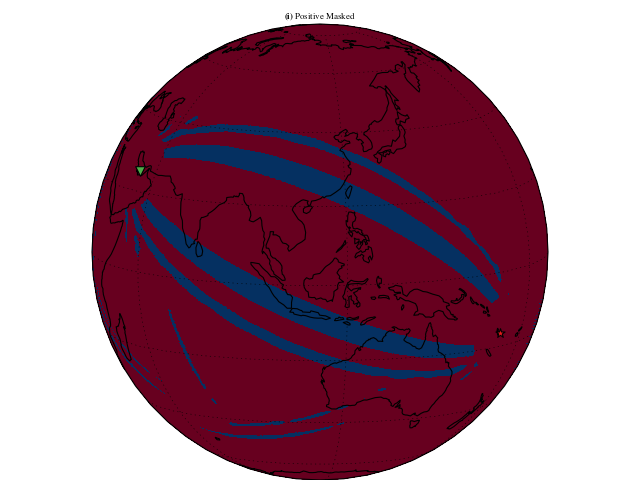

<IPython.core.display.Javascript object>


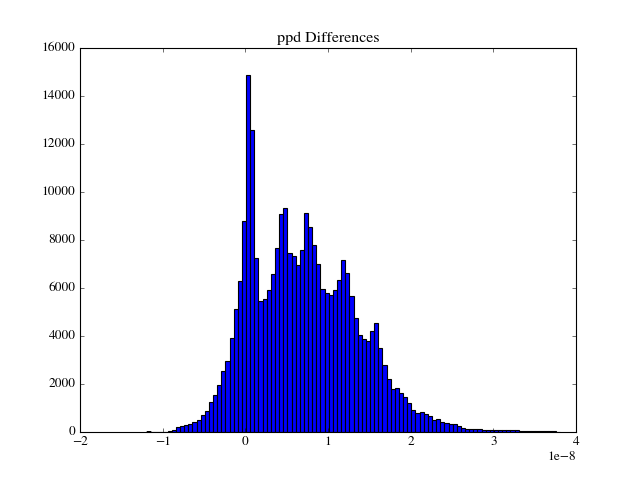

ppd
	Max absolute difference for positive region: 3.80693698787e-08 / 1.01020479093e-07 37.6848043293 at (17.33N, 59.88E)
	Min absolute difference for positive region: -1.18988112696e-08 / 4.31687263713e-09 -275.634985551 at (16.59N, 58.13E)
	Max relative difference for positive region: 1.51323145126e-08 / 4.17693302168e-09 362.282910308 at (10.04N, 62.46E)
	Min relative difference for positive region: -1.18988112696e-08 / 4.31687263713e-09 -275.634985551 at (16.59N, 58.13E)
	Abs Max difference for positive region: 3.80693698787e-08
	Abs Min difference for positive region: 9.32587340685e-15
	Average difference for positive region: 6.99297447664e-09 31.2966608613
	Average absolute difference for positive region: 7.48968910638e-09 38.5148760789


<IPython.core.display.Javascript object>


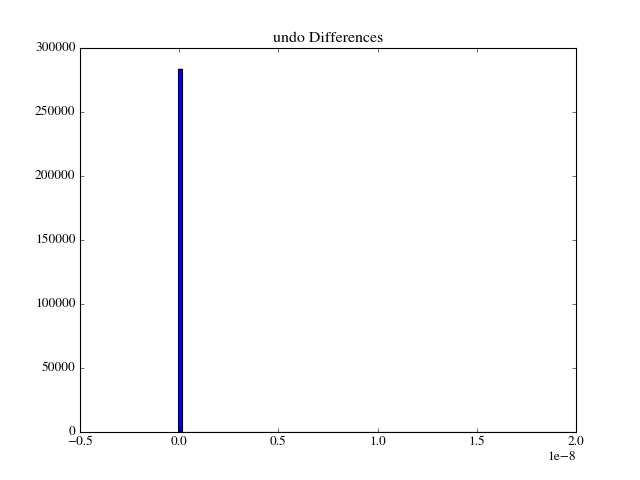

undo
	Max absolute difference for positive region: 3.01203506581e-11 / 2.68005941884e-08 0.112386876374 at (16.51N, 58.68E)
	Min absolute difference for positive region: -3.21733750752e-11 / 7.01864557584e-08 -0.0458398628732 at (17.09N, 61.84E)
	Max relative difference for positive region: 1.96391791718e-11 / 4.04300681822e-09 0.485756766061 at (16.28N, 58.68E)
	Min relative difference for positive region: -1.33424382653e-11 / 4.35767155693e-09 -0.306182742114 at (-4.38N, 163.51E)
	Abs Max difference for positive region: 3.21733750752e-11
	Abs Min difference for positive region: 0.0
	Average difference for positive region: 6.66274392928e-14 0.000541128021684
	Average absolute difference for positive region: 1.19821308691e-12 0.00709963522224


In [24]:
lat = kernel['100s-200s']['exact'].latitude
lon = kernel['100s-200s']['exact'].longitude
data = kernel['100s-200s']['exact'].alpha_kernel.copy()

# Remove a region around the source/receiver which tends to vary wildly.
source_mask = np.hypot(geod['lat1'] - lat, geod['lon1'] - lon) > 10.0
receiver_mask = np.hypot(geod['lat2'] - lat, geod['lon2'] - lon) > 10.0
# Remove all non-positive points.
mask = (data > 4e-9) & source_mask[:-1, :-1] & receiver_mask[:-1, :-1]

data[mask] = LIM
data[~mask] = -LIM

fig = plt.figure()
plot_sphere([0, 0, 1, 0.95], SurfaceData(lat, lon, data), 'Positive Masked')

exact_data = kernel['100s-200s']['exact'].alpha_kernel[mask]
for undo_type in UNDO_TYPES[1:]:
    diff = kernel['100s-200s'][undo_type].alpha_kernel[mask] - exact_data

    plt.figure()
    plt.hist(diff, bins=100)
    plt.title(undo_type + ' Differences')

    print(undo_type)
    maxind = np.argmax(diff)
    minind = np.argmin(diff)
    relmaxind = np.argmax(diff / exact_data)
    relminind = np.argmin(diff / exact_data)
    print('\tMax absolute difference for positive region:',
          diff[maxind], '/', exact_data[maxind], diff[maxind] / exact_data[maxind] * 100,
          'at (%.2fN, %.2fE)' % (lat[mask][maxind], lon[mask][maxind]))
    print('\tMin absolute difference for positive region:',
          diff[minind], '/', exact_data[minind], diff[minind] / exact_data[minind] * 100,
          'at (%.2fN, %.2fE)' % (lat[mask][minind], lon[mask][minind]))
    print('\tMax relative difference for positive region:',
          diff[relmaxind], '/', exact_data[relmaxind], diff[relmaxind] / exact_data[relmaxind] * 100,
          'at (%.2fN, %.2fE)' % (lat[mask][relmaxind], lon[mask][relmaxind]))
    print('\tMin relative difference for positive region:',
          diff[relminind], '/', exact_data[relminind], diff[relminind] / exact_data[relminind] * 100,
          'at (%.2fN, %.2fE)' % (lat[mask][relminind], lon[mask][relminind]))
    print('\tAbs Max difference for positive region:', np.max(np.abs(diff)))
    print('\tAbs Min difference for positive region:', np.min(np.abs(diff)))
    print('\tAverage difference for positive region:',
          np.mean(diff), np.mean(diff / exact_data) * 100)
    print('\tAverage absolute difference for positive region:',
          np.mean(np.abs(diff)), np.mean(np.abs(diff / exact_data)) * 100)

<IPython.core.display.Javascript object>


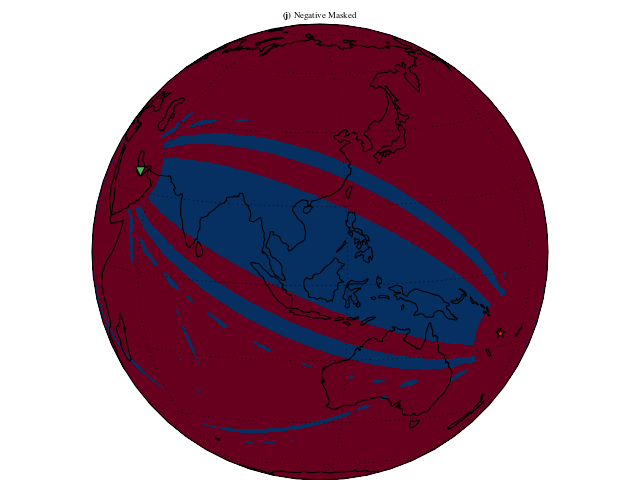

<IPython.core.display.Javascript object>


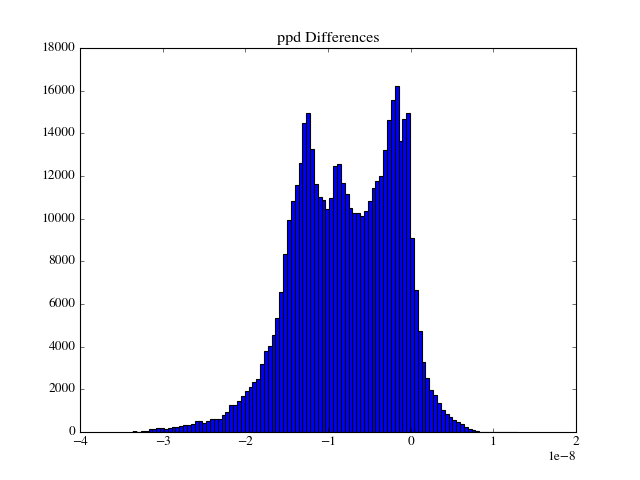

ppd
	Max absolute difference for negative region: 1.29506583235e-08 / -4.77956518807e-09 -270.958922285 at (10.75N, 61.91E)
	Min absolute difference for negative region: -3.35698615572e-08 / -1.36419814112e-07 24.6077608123 at (20.42N, 61.49E)
	Max relative difference for negative region: -1.55149184611e-08 / -4.10749634305e-09 377.722027369 at (-21.57N, 157.12E)
	Min relative difference for negative region: 1.29506583235e-08 / -4.77956518807e-09 -270.958922285 at (10.75N, 61.91E)
	Abs Max difference for negative region: 3.35698615572e-08
	Abs Min difference for negative region: 1.73194791842e-14
	Average difference for negative region: -7.96829413459e-09 22.4192784606
	Average absolute difference for negative region: 8.20831393027e-09 26.2047657359


<IPython.core.display.Javascript object>


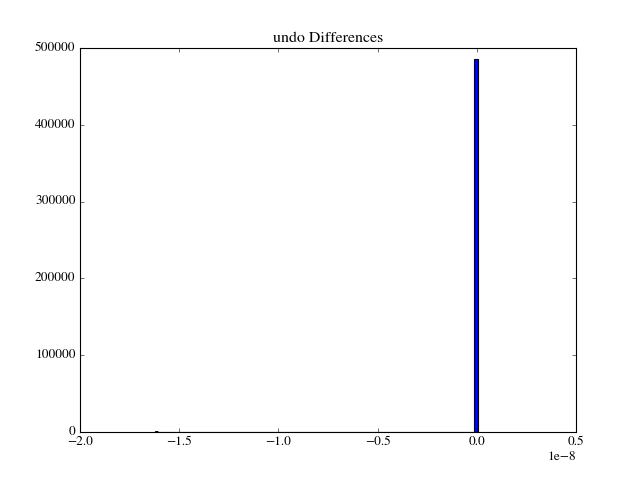

undo
	Max absolute difference for negative region: 3.68132191397e-11 / -6.66997905796e-08 -0.0551924058829 at (-16.79N, 154.31E)
	Min absolute difference for negative region: -3.8856029505e-11 / -8.17741110382e-08 0.0475162970429 at (18.51N, 63.25E)
	Max relative difference for negative region: -1.63420388333e-11 / -6.38913233431e-09 0.255778687593 at (-7.74N, 162.45E)
	Min relative difference for negative region: 1.74646963558e-11 / -4.74515637894e-09 -0.368053125357 at (15.69N, 59.38E)
	Abs Max difference for negative region: 3.8856029505e-11
	Abs Min difference for negative region: 0.0
	Average difference for negative region: -9.46575346778e-14 0.000359652103955
	Average absolute difference for negative region: 1.78381954227e-12 0.00518443316702


In [25]:
lat = kernel['100s-200s']['exact'].latitude
lon = kernel['100s-200s']['exact'].longitude
data = kernel['100s-200s']['exact'].alpha_kernel.copy()

# Remove a region around the source/receiver which tends to vary wildly.
source_mask = np.hypot(geod['lat1'] - lat, geod['lon1'] - lon) > 10.0
receiver_mask = np.hypot(geod['lat2'] - lat, geod['lon2'] - lon) > 10.0
# Remove all non-negative points.
mask = (data < -4e-9) & source_mask[:-1, :-1] & receiver_mask[:-1, :-1]

data[mask] = LIM
data[~mask] = -LIM

fig = plt.figure()
plot_sphere([0, 0, 1, 0.95], SurfaceData(lat, lon, data), 'Negative Masked')

exact_data = kernel['100s-200s']['exact'].alpha_kernel[mask]
for undo_type in UNDO_TYPES[1:]:
    diff = kernel['100s-200s'][undo_type].alpha_kernel[mask] - exact_data

    plt.figure()
    plt.hist(diff, bins=100)
    plt.title(undo_type + ' Differences')

    print(undo_type)
    maxind = np.argmax(diff)
    minind = np.argmin(diff)
    relmaxind = np.argmax(diff / exact_data)
    relminind = np.argmin(diff / exact_data)
    print('\tMax absolute difference for negative region:',
          diff[maxind], '/', exact_data[maxind], diff[maxind] / exact_data[maxind] * 100,
          'at (%.2fN, %.2fE)' % (lat[mask][maxind], lon[mask][maxind]))
    print('\tMin absolute difference for negative region:',
          diff[minind], '/', exact_data[minind], diff[minind] / exact_data[minind] * 100,
          'at (%.2fN, %.2fE)' % (lat[mask][minind], lon[mask][minind]))
    print('\tMax relative difference for negative region:',
          diff[relmaxind], '/', exact_data[relmaxind], diff[relmaxind] / exact_data[relmaxind] * 100,
          'at (%.2fN, %.2fE)' % (lat[mask][relmaxind], lon[mask][relmaxind]))
    print('\tMin relative difference for negative region:',
          diff[relminind], '/', exact_data[relminind], diff[relminind] / exact_data[relminind] * 100,
          'at (%.2fN, %.2fE)' % (lat[mask][relminind], lon[mask][relminind]))
    print('\tAbs Max difference for negative region:', np.max(np.abs(diff)))
    print('\tAbs Min difference for negative region:', np.min(np.abs(diff)))
    print('\tAverage difference for negative region:',
          np.mean(diff), np.mean(diff / exact_data) * 100)
    print('\tAverage absolute difference for negative region:',
          np.mean(np.abs(diff)), np.mean(np.abs(diff / exact_data)) * 100)

# License Statement
Copyright (C) 2016  Elliott Sales de Andrade

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.